# **<center>Hyperparameter Optimization and Data Balancing for Robust SVM Models in Healthcare</center>**


- **Mehdi ATTAOUI**

## <b>Introduction</b>

Machine Learning has become essential in domains like medical diagnosis, finance, and image recognition. Among supervised learning algorithms, Support Vector Machines (SVMs) are widely used for their strong theoretical foundation and high performance. However, SVM performance depends heavily on hyperparameter selection. Traditional tuning methods like manual search or Grid Search are often computationally expensive and poorly scalable.
This project investigates the use of a Genetic Algorithm (GA) to optimize SVM hyperparameters and compares its performance with a standard SVM implementation.

## <b>4. Dataset Description & Preprocessing</b>

In [14]:
#!pip install deap

In [ ]:
import time
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from deap import base, creator, tools, algorithms
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import warnings

warnings.filterwarnings("ignore")

In [74]:
df = pd.read_csv('/kaggle/input/liver-disorders/Indian Liver Patient Dataset (ILPD).csv')

In [75]:
df.shape

(583, 11)

In [76]:
df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


Columns Explanation:


Age → Patient’s age in years.

Gender → Male/Female.

TB → Total Bilirubin (mg/dL). High values often indicate liver problems.

DB → Direct Bilirubin (mg/dL). Another important liver function test.

Alkphos → Alkaline Phosphatase enzyme level. High values can signal liver or bone disorders.

Sgpt → Serum Glutamic Pyruvic Transaminase (ALT/SGPT), enzyme level related to liver function.

Sgot → Serum Glutamic Oxaloacetic Transaminase (AST/SGOT), another enzyme test for liver function.

TP → Total Proteins (g/dL). Lower levels may show poor liver health.

ALB → Albumin (g/dL), a protein made by the liver.

A/G Ratio → Albumin/Globulin Ratio. Normally >1; imbalance may indicate liver dysfunction.

Selector → Target column:

1 → Patient has liver disease

2 → Patient does not have liver disease

In [78]:
df.dtypes

Age            int64
Gender        object
TB           float64
DB           float64
Alkphos        int64
Sgpt           int64
Sgot           int64
TP           float64
ALB          float64
A/G Ratio    float64
Selector       int64
dtype: object

In [80]:
df.duplicated().sum()

13

In [81]:
df.isna().sum()

Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    4
Selector     0
dtype: int64

In [82]:
df.value_counts('Selector')

Selector
1    416
2    167
Name: count, dtype: int64

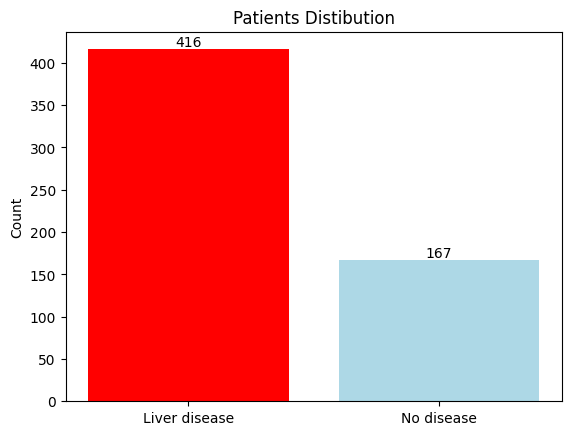

In [83]:
health = ['Liver disease','No disease']
count = df['Selector'].value_counts()

plt.bar(health,count,color=['red','lightblue'])

plt.title('Patients Distibution')
plt.ylabel('Count')

for i, count in enumerate(count):
    plt.text(i,count,str(count),ha='center',va='bottom')
    
plt.show()

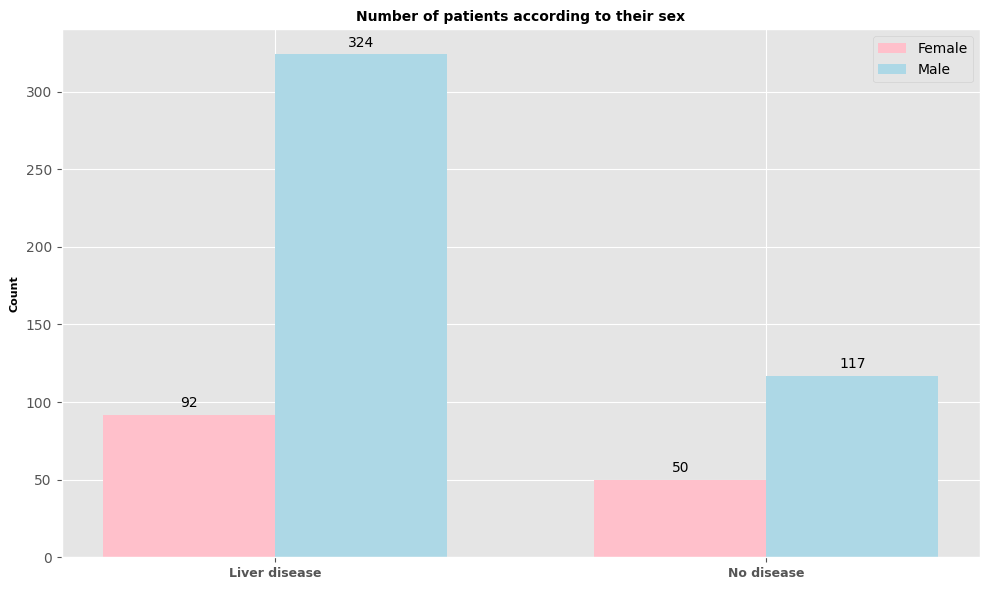

In [ ]:
plt.style.use('ggplot')

df_Selector_Gender = pd.crosstab(df['Selector'], df['Gender'])

labels = ['Liver disease','No disease']  
values_no = df_Selector_Gender.iloc[:,0]   
values_yes = df_Selector_Gender.iloc[:,1] 

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - width/2, values_no, width, label='Female', color='pink')
rects2 = ax.bar(x + width/2, values_yes, width, label='Male', color='lightblue')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height}',
            xy=(rect.get_x() + rect.get_width()/2, height),
            xytext=(0, 3.1),
            textcoords='offset points',
            ha='center',
            va='bottom'
        )

autolabel(rects1)
autolabel(rects2)

ax.set_ylabel("Count", fontsize=8, fontweight='bold', color='black')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=9, fontweight='bold')
ax.set_title("Number of patients according to their sex", fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

In [85]:
df = df.drop_duplicates().reset_index(drop=True)

The dataset shows only 4 missing values, all in the A/G Ratio (Albumin/Globulin Ratio) column, while all other features contain complete information. Since A/G Ratio is a clinically meaningful biomarker where normal values are typically > 1 and lower ratios may indicate liver dysfunction, removing these rows would discard potentially informative samples in an already small dataset (≈ 580 rows). Because the number of missing values is extremely small (<1%), the most logical approach is to fill them with the mean rather than drop the samples. This preserves the dataset size and avoids biasing the distribution while maintaining the clinical relevance of the feature.

In [ ]:
df['A/G Ratio'] = df['A/G Ratio'].fillna(df['A/G Ratio'].mean())

We should convert the target into binary numeric labels:

In [ ]:
df['Selector'] = df['Selector'].map({1:1, 2:0})

In [ ]:
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

In [89]:
df.value_counts('Gender')

Gender
1    430
0    140
Name: count, dtype: int64

In [90]:
X = df.drop('Selector', axis=1)
y = df['Selector']

- Scale continuous features only:

In [ ]:
continuous_features = ['Age','TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G Ratio']
scaler = StandardScaler()

X_scaled = X.copy()
X_scaled[continuous_features] = scaler.fit_transform(X[continuous_features])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## <b>5. Baseline SVM Implementation</b>

In [ ]:
svm_baseline = SVC(kernel='rbf', C=1.0, gamma='scale', probability=False, random_state=42)

t0 = time.time()
svm_baseline.fit(X_train, y_train)
t1 = time.time()
baseline_train_time = t1 - t0

- Predictions

In [ ]:
y_pred_baseline = svm_baseline.predict(X_test)

In [ ]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_report = classification_report(y_test, y_pred_baseline, digits=4)
baseline_confmat = confusion_matrix(y_test, y_pred_baseline)
n_support_vectors_baseline = np.sum(svm_baseline.n_support_)

print("\n=== Baseline SVM Results ===")
print(f"Train time (s): {baseline_train_time:.4f}")
print(f"Test accuracy: {baseline_accuracy:.4f}")
print("Classification report:\n", baseline_report)
print("Number of support vectors (total):", n_support_vectors_baseline)


=== Baseline SVM Results ===
Train time (s): 0.0136
Test accuracy: 0.7105
Classification report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        33
           1     0.7105    1.0000    0.8308        81

    accuracy                         0.7105       114
   macro avg     0.3553    0.5000    0.4154       114
weighted avg     0.5048    0.7105    0.5903       114

Number of support vectors (total): 299


- Confusion Matrix Heatmap

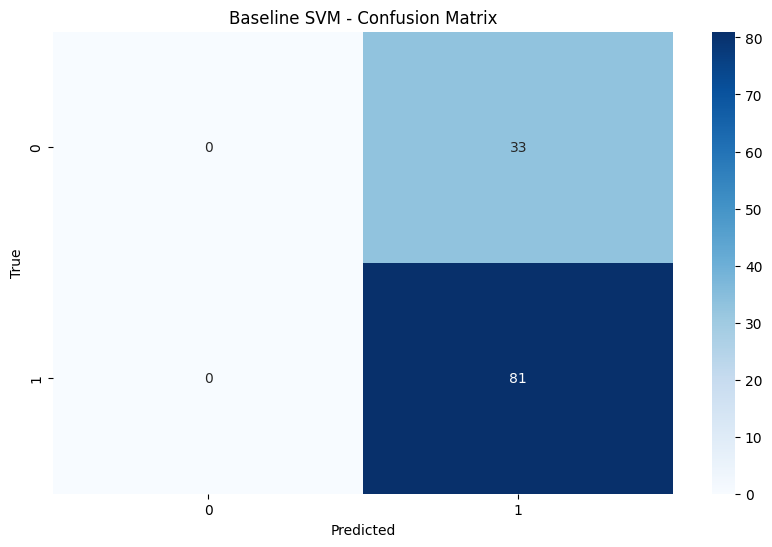

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(baseline_confmat, annot=True, fmt='d', cmap="Blues")
plt.title("Baseline SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## <b>6. Optimized SVM Using Custom GA</b>

- Kernel mapping and GA hyperparams:

In [ ]:
kernel_map = {0: 'linear', 1: 'rbf', 2: 'poly'}

pop_size = 24
n_gen = 30
tournament_k = 3
cx_prob = 0.8
mut_prob = 0.2
random_state = 42

np.random.seed(random_state)
random.seed(random_state)

- Fitness function:

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

eval_count = 0
history = []
all_evals = []

def evaluate_chromosome(chrom):
    """
    Input: chrom = [log10_C, log10_gamma, kernel_idx, degree_int, cw_flag]
    Output: mean CV accuracy (float)
    """
    global eval_count, all_evals

    log10_C = float(chrom[0])
    log10_gamma = float(chrom[1])
    kernel_idx = int(round(chrom[2]))
    degree_int = int(round(chrom[3]))
    cw_flag = int(round(chrom[4]))

    kernel_idx = int(np.clip(kernel_idx, 0, 2))
    degree_int = int(np.clip(degree_int, 2, 5))
    cw_flag = int(np.clip(cw_flag, 0, 1))

    C = 10.0 ** float(np.clip(log10_C, -6, 6))
    gamma = 10.0 ** float(np.clip(log10_gamma, -8, 3))

    kernel = kernel_map[kernel_idx]
    degree = degree_int
    class_weight = 'balanced' if cw_flag == 1 else None

    if kernel == 'linear':
        clf = SVC(kernel='linear', C=C, class_weight=class_weight, random_state=random_state)
    elif kernel == 'rbf':
        clf = SVC(kernel='rbf', C=C, gamma=gamma, class_weight=class_weight, random_state=random_state)
    else:  
        clf = SVC(kernel='poly', C=C, gamma=gamma, degree=degree, class_weight=class_weight, random_state=random_state)

    # NOTE: 
    try:
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=1)
        mean_score = float(np.mean(scores))
    except Exception as e:
        print("CV failed for chrom:", chrom, "error:", e)
        mean_score = 0.0

    eval_count += 1
    all_evals.append((mean_score, copy.deepcopy(chrom)))
    return mean_score

- Chromosome initialization, Tournament selection, Crossover and Mutation:

In [ ]:
def random_chromosome():
    return [
        np.random.uniform(-3.0, 3.0), 
        np.random.uniform(-4.0, 1.0),   
        np.random.randint(0, 3), 
        np.random.randint(2, 6), 
        np.random.randint(0, 2)     
    ]

def tournament_selection(pop, fitnesses, k=3):
    k = min(k, len(pop))
    selected_idx = np.random.choice(len(pop), k, replace=False)
    best = selected_idx[0]
    for idx in selected_idx:
        if fitnesses[idx] > fitnesses[best]:
            best = idx
    return copy.deepcopy(pop[best])

def crossover(parent1, parent2):
    child1, child2 = copy.deepcopy(parent1), copy.deepcopy(parent2)

    alpha = np.random.uniform(0, 1)
    child1[0] = alpha * parent1[0] + (1 - alpha) * parent2[0]
    child2[0] = alpha * parent2[0] + (1 - alpha) * parent1[0]

    alpha = np.random.uniform(0, 1)
    child1[1] = alpha * parent1[1] + (1 - alpha) * parent2[1]
    child2[1] = alpha * parent2[1] + (1 - alpha) * parent1[1]

    if np.random.rand() < 0.5:
        child1[2], child2[2] = parent2[2], parent1[2]
    if np.random.rand() < 0.5:
        child1[3], child2[3] = parent2[3], parent1[3]
    if np.random.rand() < 0.5:
        child1[4], child2[4] = parent2[4], parent1[4]

    return child1, child2

def mutate(chrom, mut_prob=0.2):
    if np.random.rand() < mut_prob:
        chrom[0] += np.random.normal(0, 0.5)
        chrom[0] = float(np.clip(chrom[0], -6, 6))
    if np.random.rand() < mut_prob:
        chrom[1] += np.random.normal(0, 0.5)
        chrom[1] = float(np.clip(chrom[1], -8, 3))
    if np.random.rand() < mut_prob:
        chrom[2] = int(np.random.randint(0, 3))
    if np.random.rand() < mut_prob:
        chrom[3] = int(np.random.randint(2, 6))
    if np.random.rand() < mut_prob:
        chrom[4] = int(np.random.randint(0, 2))

    return chrom

- GA main loop:

In [ ]:
def run_ga(pop_size=20, n_gen=20):

    pop = [random_chromosome() for _ in range(pop_size)]
    fitnesses = [None] * pop_size
    best_history = []
    mean_history = []

    for i, ind in enumerate(pop):
        fitnesses[i] = evaluate_chromosome(ind)

    best_idx = int(np.argmax(fitnesses))
    best = copy.deepcopy(pop[best_idx])
    best_fitness = fitnesses[best_idx]
    print(f"Initial best fitness: {best_fitness:.4f}")

    best_history.append(best_fitness)
    mean_history.append(np.mean(fitnesses))

    for gen in range(1, n_gen + 1):
        new_pop = []
        sorted_idx = np.argsort(fitnesses)[::-1]
        elite_count = max(1, int(0.05 * pop_size))
        for e in range(elite_count):
            new_pop.append(copy.deepcopy(pop[sorted_idx[e]]))

        while len(new_pop) < pop_size:
            p1 = tournament_selection(pop, fitnesses, k=tournament_k)
            p2 = tournament_selection(pop, fitnesses, k=tournament_k)

            if np.random.rand() < cx_prob:
                c1, c2 = crossover(p1, p2)
            else:
                c1, c2 = copy.deepcopy(p1), copy.deepcopy(p2)

            c1 = mutate(c1, mut_prob=mut_prob)
            c2 = mutate(c2, mut_prob=mut_prob)

            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)

        pop = new_pop[:pop_size]

        fitnesses = [evaluate_chromosome(ind) for ind in pop]

        best_idx = int(np.argmax(fitnesses))
        if fitnesses[best_idx] > best_fitness:
            best_fitness = fitnesses[best_idx]
            best = copy.deepcopy(pop[best_idx])

        best_history.append(best_fitness)
        mean_history.append(np.mean(fitnesses))

        print(f"Gen {gen}/{n_gen} - Best fitness: {best_fitness:.4f} - Mean fitness: {mean_history[-1]:.4f} - Eval count: {eval_count}")

    return best, best_fitness, best_history, mean_history

- Run GA:

In [ ]:
start_time_ga = time.time()
best_chrom, best_fit, best_history, mean_history = run_ga(pop_size=pop_size, n_gen=n_gen)
ga_time = time.time() - start_time_ga

print("\nGA finished in {:.2f}s with {} evaluations.".format(ga_time, eval_count))
print("Best fitness (CV accuracy): {:.4f}".format(best_fit))
print("Best chromosome:", best_chrom)

Initial best fitness: 0.7127
Gen 1/30 - Best fitness: 0.7127 - Mean fitness: 0.6884 - Eval count: 792
Gen 2/30 - Best fitness: 0.7127 - Mean fitness: 0.7066 - Eval count: 816
Gen 3/30 - Best fitness: 0.7127 - Mean fitness: 0.7020 - Eval count: 840
Gen 4/30 - Best fitness: 0.7149 - Mean fitness: 0.6941 - Eval count: 864
Gen 5/30 - Best fitness: 0.7149 - Mean fitness: 0.7052 - Eval count: 888
Gen 6/30 - Best fitness: 0.7149 - Mean fitness: 0.6976 - Eval count: 912
Gen 7/30 - Best fitness: 0.7149 - Mean fitness: 0.7065 - Eval count: 936
Gen 8/30 - Best fitness: 0.7149 - Mean fitness: 0.7060 - Eval count: 960
Gen 9/30 - Best fitness: 0.7149 - Mean fitness: 0.7068 - Eval count: 984
Gen 10/30 - Best fitness: 0.7149 - Mean fitness: 0.7086 - Eval count: 1008
Gen 11/30 - Best fitness: 0.7193 - Mean fitness: 0.6956 - Eval count: 1032
Gen 12/30 - Best fitness: 0.7193 - Mean fitness: 0.6935 - Eval count: 1056
Gen 13/30 - Best fitness: 0.7193 - Mean fitness: 0.7092 - Eval count: 1080
Gen 14/30 - Be

- Decode best chromosome:

In [ ]:
def decode_chrom(chrom):
    log10_C = float(chrom[0])
    log10_gamma = float(chrom[1])
    kernel_idx = int(round(chrom[2]))
    degree_int = int(round(chrom[3]))
    cw_flag = int(round(chrom[4]))

    kernel_idx = int(np.clip(kernel_idx, 0, 2))
    degree_int = int(np.clip(degree_int, 2, 5))
    cw_flag = int(np.clip(cw_flag, 0, 1))

    C = 10.0 ** float(np.clip(log10_C, -6, 6))
    gamma = 10.0 ** float(np.clip(log10_gamma, -8, 3))
    kernel = kernel_map[kernel_idx]
    degree = degree_int
    class_weight = 'balanced' if cw_flag == 1 else None
    return dict(C=C, gamma=gamma, kernel=kernel, degree=degree, class_weight=class_weight)

best_params = decode_chrom(best_chrom)
print("Decoded best params:", best_params)

Decoded best params: {'C': 1.048705270339561, 'gamma': 2.487599808216934, 'kernel': 'rbf', 'degree': 5, 'class_weight': None}


- Train SVM with best params on full training set and evaluate on test set:

In [ ]:
if best_params['kernel'] == 'linear':
    svm_best = SVC(kernel='linear', C=best_params['C'], class_weight=best_params['class_weight'], random_state=random_state)
elif best_params['kernel'] == 'rbf':
    svm_best = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], class_weight=best_params['class_weight'], random_state=random_state)
else:
    svm_best = SVC(kernel='poly', C=best_params['C'], gamma=best_params['gamma'],
                   degree=best_params['degree'], class_weight=best_params['class_weight'], random_state=random_state)

t0 = time.time()
svm_best.fit(X_train, y_train)
t1 = time.time()
best_train_time = t1 - t0

In [50]:
y_pred_best = svm_best.predict(X_test)
best_accuracy_test = accuracy_score(y_test, y_pred_best)
best_report = classification_report(y_test, y_pred_best, digits=4)
best_confmat = confusion_matrix(y_test, y_pred_best)
n_support_vectors_best = np.sum(svm_best.n_support_)

print("\n=== Optimized SVM Results ===")
print(f"GA time (s): {ga_time:.2f}, SVM train time (s): {best_train_time:.4f}")
print("Best CV fitness (accuracy):", best_fit)
print("Test accuracy:", best_accuracy_test)
print("Classification report:\n", best_report)
print("Number of support vectors (total):", n_support_vectors_best)


=== Optimized SVM Results ===
GA time (s): 221.62, SVM train time (s): 0.0161
Best CV fitness (accuracy): 0.7236980410893454
Test accuracy: 0.7192982456140351
Classification report:
               precision    recall  f1-score   support

           0     0.6667    0.0606    0.1111        33
           1     0.7207    0.9877    0.8333        81

    accuracy                         0.7193       114
   macro avg     0.6937    0.5241    0.4722       114
weighted avg     0.7051    0.7193    0.6243       114

Number of support vectors (total): 436


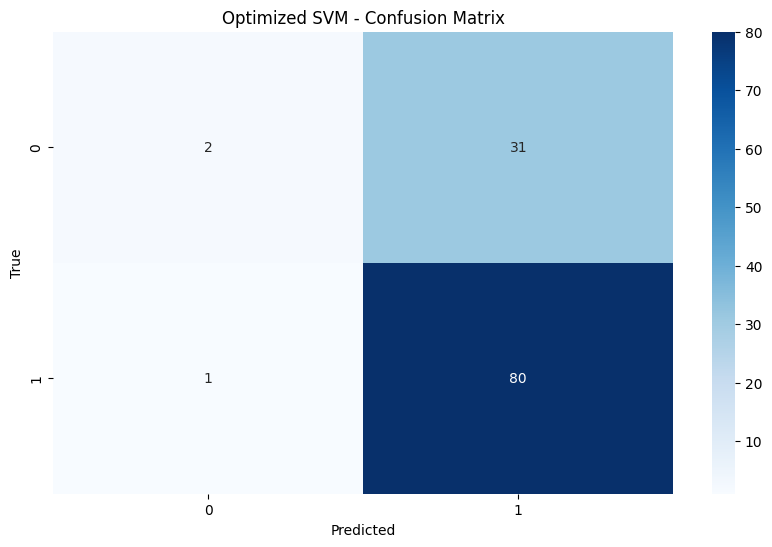

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(best_confmat, annot=True, fmt='d', cmap="Blues")
plt.title("Optimized SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

- Convergence plot:

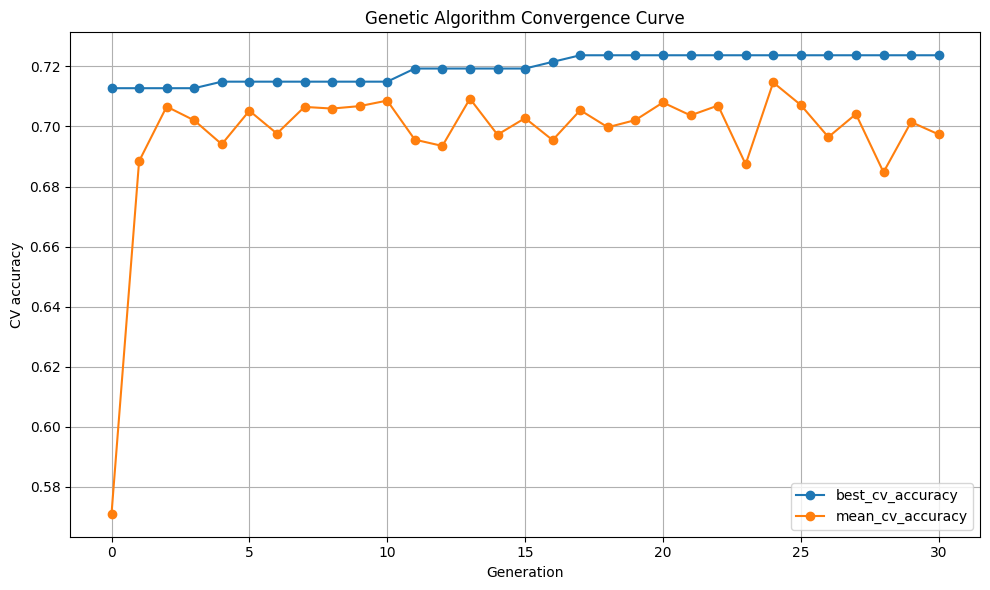

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(best_history, label='best_cv_accuracy', marker='o')
plt.plot(mean_history, label='mean_cv_accuracy', marker='o')
plt.xlabel("Generation")
plt.ylabel("CV accuracy")
plt.title("Genetic Algorithm Convergence Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## <b>7. Data Balancing and GA Optimization</b>

The ILPD dataset is **strongly imbalanced**, containing far more patients with liver disease (label 1) than healthy patients (label 0). This imbalance biases SVM toward predicting the majority class, which results in:

* lower recall for the minority class (healthy patients),
* lower F1-score,
* worse generalization.

Since we are later comparing models using metrics such as **accuracy, F1-score, #Support Vectors, and execution time**, balancing is crucial for a fair evaluation.

- Description of KMeans-SMOTE:

**KMeans-SMOTE** enhances classical SMOTE by:

1. **Clustering samples** using KMeans.
2. **Identifying clusters** where the minority class is underrepresented.
3. **Generating synthetic samples** inside these clusters, avoiding noisy regions.
4. Producing **higher-quality synthetic data** with less risk of overfitting.

Advantages over classical SMOTE:

* Avoids creating synthetic points in overlapping/unsafe regions.
* Better for datasets with heterogeneous distributions (like ILPD).

In [ ]:
from imblearn.over_sampling import KMeansSMOTE

kms = KMeansSMOTE(
    k_neighbors=5,
    cluster_balance_threshold=0.1,
    random_state=42
)

X_train_kms, y_train_kms = kms.fit_resample(X_train, y_train)

- Before vs After Balancing:

In [14]:
class_counts_before = y_train.value_counts()
class_counts_after = y_train_kms.value_counts()

comparison_table = pd.DataFrame({
    'Class': ['Liver Disease', 'No Disease'],
    'Count Before SMOTE': class_counts_before.values,
    'Count After SMOTE': class_counts_after.values
})

print("Class Distribution Before and After KMeans-SMOTE:")
print(comparison_table)

Class Distribution Before and After KMeans-SMOTE:
           Class  Count Before SMOTE  Count After SMOTE
0  Liver Disease                 325                327
1     No Disease                 131                325


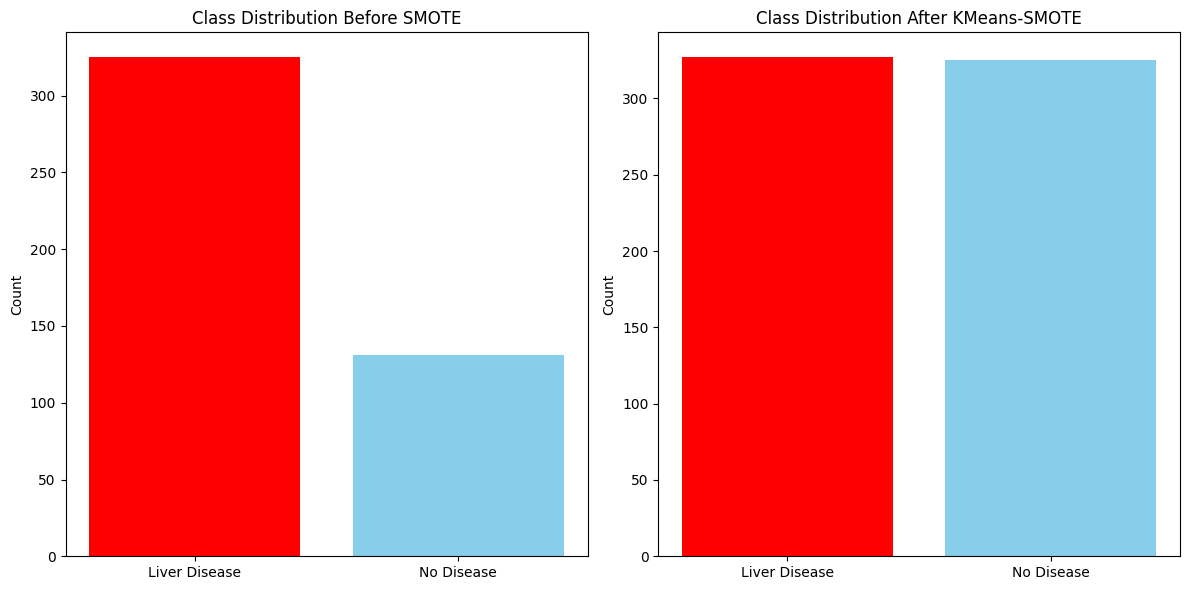

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(['Liver Disease', 'No Disease'], class_counts_before, color=['red', 'skyblue'])
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_ylabel('Count')

axes[1].bar(['Liver Disease', 'No Disease'], class_counts_after, color=['red', 'skyblue'])
axes[1].set_title('Class Distribution After KMeans-SMOTE')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

- Train SVM on balanced data:

In [ ]:
svm_kms = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

t0 = time.time()
svm_kms.fit(X_train_kms, y_train_kms)
t1 = time.time()

kms_train_time = t1 - t0

- Predictions and metrics:

In [ ]:
y_pred_kms = svm_kms.predict(X_test)

In [18]:
accuracy_kms = accuracy_score(y_test, y_pred_kms)
report_kms = classification_report(y_test, y_pred_kms, digits=4)
confmat_kms = confusion_matrix(y_test, y_pred_kms)
n_support_vectors_kms = np.sum(svm_kms.n_support_)

print("\n=== Baseline SVM (After KMeans-SMOTE) ===")
print(f"Training Time (s): {kms_train_time:.4f}")
print(f"Accuracy: {accuracy_kms:.4f}")

print("\nClassification Report:")
print(report_kms)

print("Number of Support Vectors (total):", n_support_vectors_kms)


=== Baseline SVM (After KMeans-SMOTE) ===
Training Time (s): 0.0786
Accuracy: 0.6842

Classification Report:
              precision    recall  f1-score   support

           0     0.4681    0.6667    0.5500        33
           1     0.8358    0.6914    0.7568        81

    accuracy                         0.6842       114
   macro avg     0.6520    0.6790    0.6534       114
weighted avg     0.7294    0.6842    0.6969       114

Number of Support Vectors (total): 448


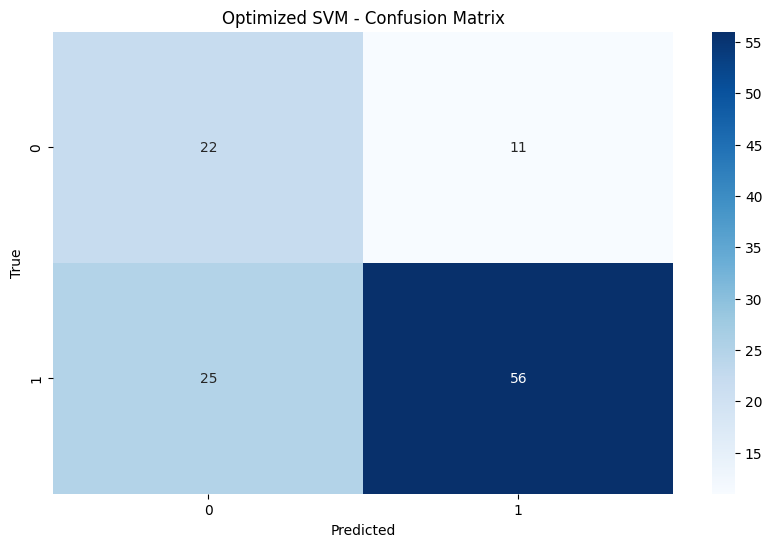

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confmat_kms, annot=True, fmt='d', cmap="Blues")
plt.title("Optimized SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

    GA Optimization of SVM on Balanced Data:

In [ ]:
KERNEL_OPTIONS = ["rbf", "poly", "sigmoid"]

def evaluate_svm(individual):
    """
    Individual format:
    [
        C (float),
        gamma (float),
        kernel_index (int)
    ]
    """
    C, gamma, kernel_idx = individual
    kernel = KERNEL_OPTIONS[int(kernel_idx)]

    C = max(C, 0.0001)
    gamma = max(gamma, 0.0001)

    model = SVC(
        C=C,
        gamma=gamma,
        kernel=kernel,
        probability=False
    )

    scores = cross_val_score(model, X_train_kms, y_train_kms, cv=5, scoring="accuracy")

    return (scores.mean(),)

- GA Setup:

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("C_attr", random.uniform, 0.1, 20)
toolbox.register("gamma_attr", random.uniform, 0.0001, 2)
toolbox.register("kernel_attr", random.randint, 0, len(KERNEL_OPTIONS) - 1)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.C_attr, toolbox.gamma_attr, toolbox.kernel_attr), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_svm)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=3)

POP_SIZE = 20
N_GEN = 10
MUT_PB = 0.3
CX_PB = 0.7

- Run GA:

In [ ]:
print("\n=== Running Genetic Algorithm on Balanced Dataset ===")
t0 = time.time()

population = toolbox.population(n=POP_SIZE)
hall_of_fame = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

population, log = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=CX_PB,
    mutpb=MUT_PB,
    ngen=N_GEN,
    stats=stats,
    halloffame=hall_of_fame,
    verbose=True
)

t1 = time.time()
ga_time = t1 - t0


=== Running Genetic Algorithm on Balanced Dataset ===
gen	nevals	avg     	max     
0  	20    	0.685596	0.834457
1  	18    	0.739849	0.83906 
2  	14    	0.785056	0.83906 
3  	14    	0.820045	0.83906 
4  	19    	0.815509	0.83906 
5  	18    	0.817735	0.83906 
6  	18    	0.837146	0.840587
7  	18    	0.831854	0.840587
8  	15    	0.823404	0.842114
9  	15    	0.820486	0.842114
10 	13    	0.841351	0.842114


- Best parameters found:

In [ ]:
best_individual = hall_of_fame[0]
best_C, best_gamma, best_kernel_idx = best_individual
best_kernel = KERNEL_OPTIONS[int(best_kernel_idx)]

print("\n=== Best GA Hyperparameters (Balanced Data) ===")
print(f"C = {best_C}")
print(f"gamma = {best_gamma}")
print(f"kernel = {best_kernel}")
print(f"GA optimization time (s): {ga_time:.4f}")


=== Best GA Hyperparameters (Balanced Data) ===
C = 12.328602647521844
gamma = 1.8265100351566868
kernel = rbf
GA optimization time (s): 181.0191


- Train Final SVM with Best GA Parameters:

In [ ]:
svm_ga = SVC(
    C=best_C,
    gamma=best_gamma,
    kernel=best_kernel,
    probability=True,
    random_state=42
)

t0 = time.time()
svm_ga.fit(X_train_kms, y_train_kms)
t1 = time.time()

ga_train_time = t1 - t0
y_pred_ga = svm_ga.predict(X_test)

- Final Evaluation After GA Optimization:

In [ ]:
accuracy_ga = accuracy_score(y_test, y_pred_ga)
report_ga = classification_report(y_test, y_pred_ga, digits=4)
confmat_ga = confusion_matrix(y_test, y_pred_ga)
n_support_vectors_ga = np.sum(svm_ga.n_support_)

print("\n=== Optimized SVM (GA + KMeans-SMOTE) ===")
print(f"Test Accuracy: {accuracy_ga:.4f}")
print(f"Training Time (s): {ga_train_time:.4f}")

print("\nClassification Report:")
print(report_ga)
print("Number of Support Vectors (total):", n_support_vectors_ga)


=== Optimized SVM (GA + KMeans-SMOTE) ===
Test Accuracy: 0.7456
Training Time (s): 0.1226

Classification Report:
              precision    recall  f1-score   support

           0     0.5909    0.3939    0.4727        33
           1     0.7826    0.8889    0.8324        81

    accuracy                         0.7456       114
   macro avg     0.6868    0.6414    0.6525       114
weighted avg     0.7271    0.7456    0.7283       114

Number of Support Vectors (total): 457


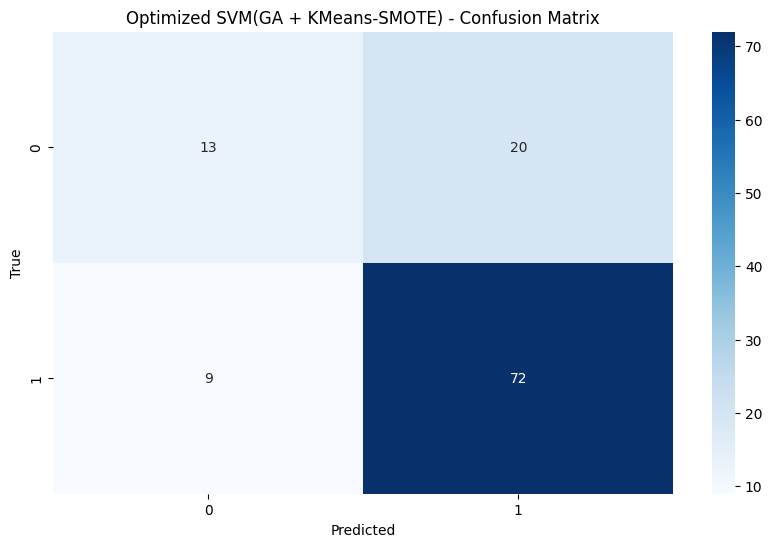

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confmat_ga, annot=True, fmt='d', cmap="Blues")
plt.title("Optimized SVM(GA + KMeans-SMOTE) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## <b>8. Evaluation, Analysis & Discussion</b>

In [ ]:
results_table = pd.DataFrame({
    "Model": [
        "Baseline SVM",
        "GA-Optimized SVM",
        "Baseline SVM + KMeans-SMOTE",
        "GA-Optimized SVM + KMeans-SMOTE"
    ],
    "Accuracy": [
        baseline_accuracy,
        best_accuracy_test,
        accuracy_kms,
        accuracy_ga
    ],
    "Train Time (s)": [
        baseline_train_time,
        best_train_time,
        baseline_train_time, 
        ga_train_time
    ],
    "GA Time (s)": [
        0,
        ga_time,
        0,
        ga_time
    ],
    "Support Vectors": [
        n_support_vectors_baseline,
        n_support_vectors_best,
        n_support_vectors_kms,
        n_support_vectors_ga
    ]
})

results_table.style.background_gradient(cmap="Blues")

,Model,Accuracy,Train Time (s),GA Time (s),Support Vectors
0,Baseline SVM,0.710526,0.013600,0.000000,299
1,GA-Optimized SVM,0.719298,0.016119,221.623227,436
2,Baseline SVM + KMeans-SMOTE,0.684211,0.013600,0.000000,448
3,GA-Optimized SVM + KMeans-SMOTE,0.745614,0.122628,221.623227,457


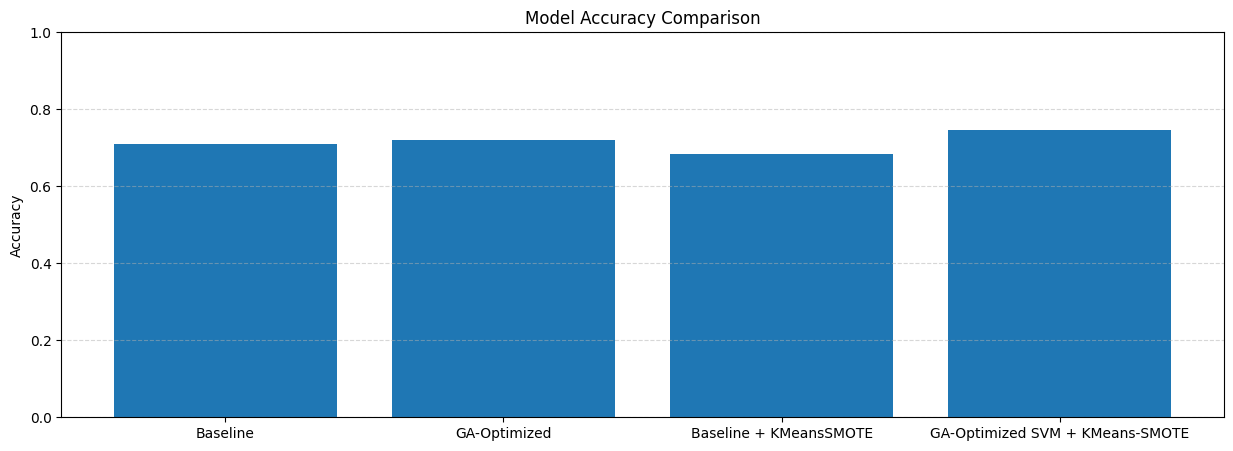

In [56]:
plt.figure(figsize=(15,5))
plt.bar(
    ["Baseline", "GA-Optimized", "Baseline + KMeansSMOTE", "GA-Optimized SVM + KMeans-SMOTE"],
    [baseline_accuracy, best_accuracy_test, accuracy_kms, accuracy_ga]
)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

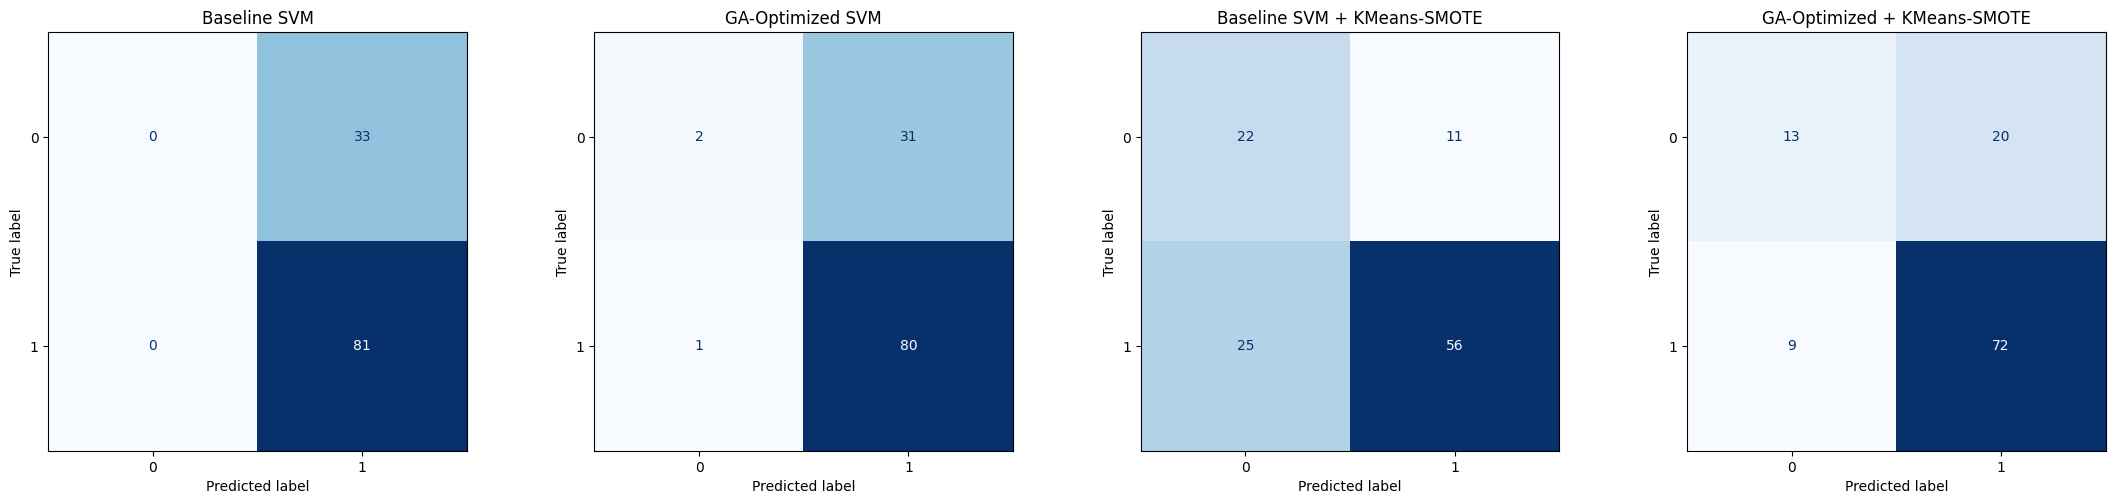

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1,4, figsize=(22,5))

titles = [
    "Baseline SVM",
    "GA-Optimized SVM",
    "Baseline SVM + KMeans-SMOTE",
    "GA-Optimized + KMeans-SMOTE"
]

cms = [
    baseline_confmat,
    best_confmat,
    confmat_kms,
    confmat_ga
]

for ax, cm, title in zip(axes, cms, titles):

    ax.grid(False)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)

    ax.grid(False)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

pr_table = pd.DataFrame({
    "Model": [
        "Baseline",
        "GA-Optimized",
        "Baseline + KMeans-SMOTE",
        "GA-Optimized + KMeans-SMOTE"
    ],
    "Precision": [
        precision_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_best),
        precision_score(y_test, y_pred_kms),
        precision_score(y_test, y_pred_ga)
    ],
    "Recall": [
        recall_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_best),
        recall_score(y_test, y_pred_kms),
        recall_score(y_test, y_pred_ga)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_best),
        f1_score(y_test, y_pred_kms),
        f1_score(y_test, y_pred_ga)
    ]
})

pr_table.style.background_gradient(cmap="Purples")

,Model,Precision,Recall,F1-score
0,Baseline,0.710526,1.000000,0.830769
1,GA-Optimized,0.720721,0.987654,0.833333
2,Baseline + KMeans-SMOTE,0.835821,0.691358,0.756757
3,GA-Optimized + KMeans-SMOTE,0.782609,0.888889,0.832370


In [65]:
pop_size = 20
generations = 15
n_evaluations = pop_size * generations

print("Total GA objective evaluations:", n_evaluations)

Total GA objective evaluations: 300


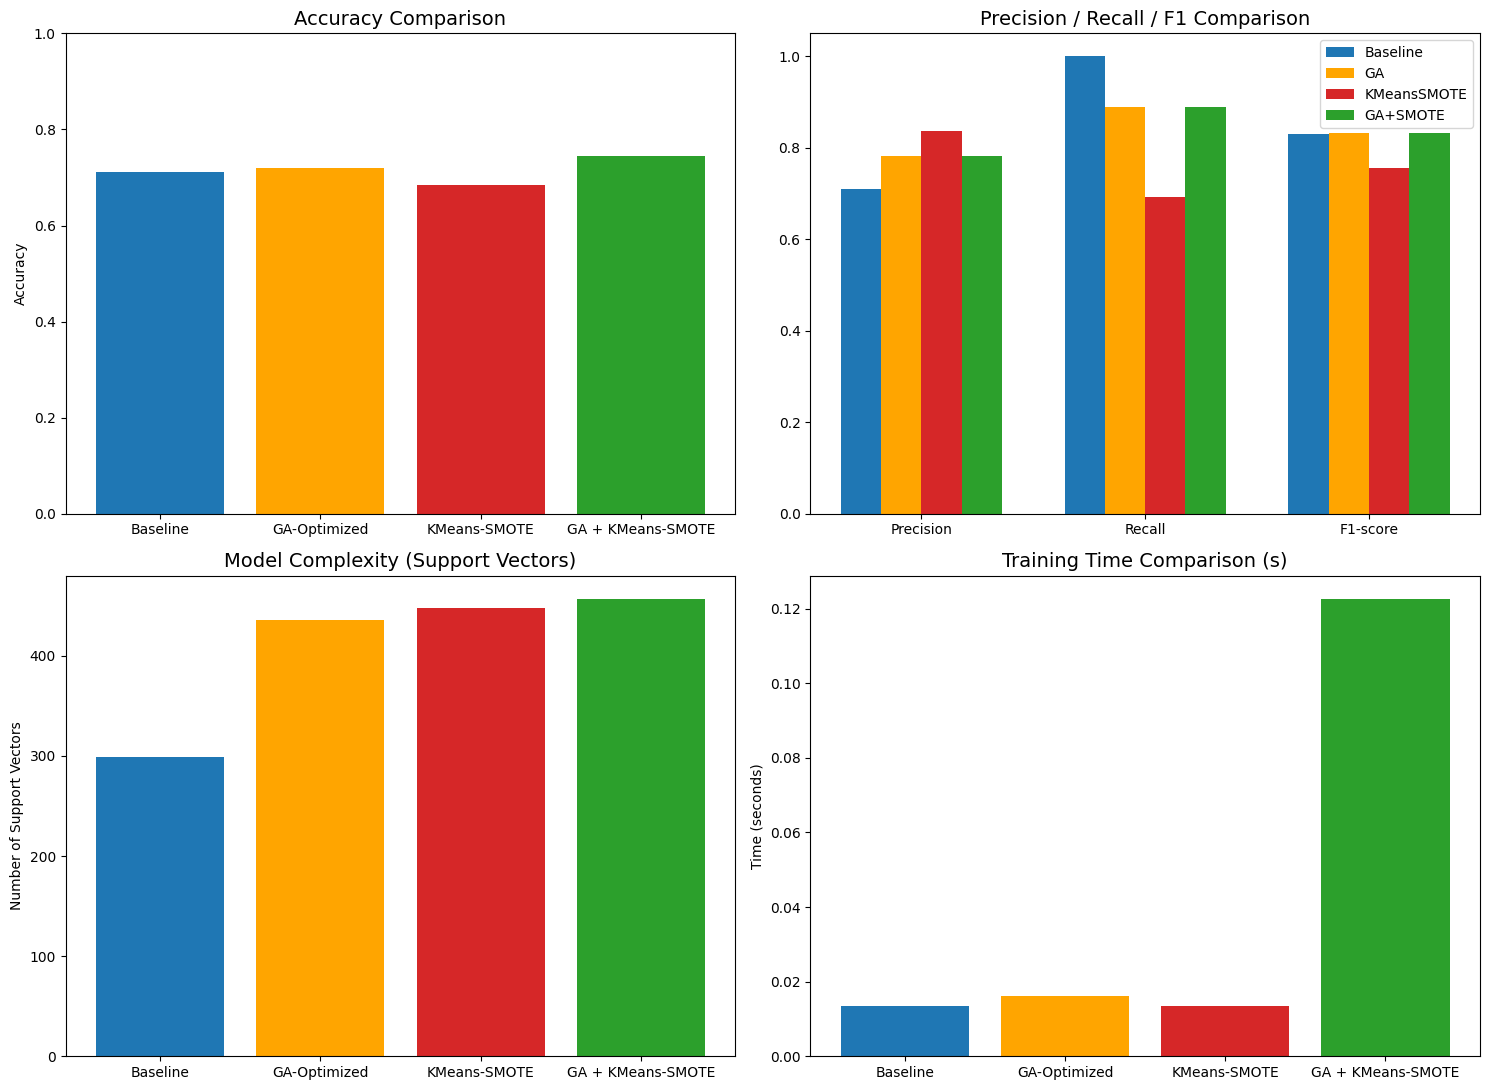

In [ ]:
colors = {
    "Baseline": "#1f77b4",
    "GA": "orange",
    "KMeansSMOTE": "#d62728",
    "GA+SMOTE": "#2ca02c"
}

models = [
    "Baseline",
    "GA-Optimized",
    "KMeans-SMOTE",
    "GA + KMeans-SMOTE"
]

acc_values = [
    baseline_accuracy,
    best_accuracy_test,
    accuracy_kms,
    accuracy_ga
]

sv_values = [
    n_support_vectors_baseline,
    n_support_vectors_best,
    n_support_vectors_kms,
    n_support_vectors_ga
]

train_times = [
    baseline_train_time,
    best_train_time,
    baseline_train_time,
    ga_train_time
]

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

axes[0,0].bar(
    models,
    acc_values,
    color=[
        colors["Baseline"], 
        colors["GA"], 
        colors["KMeansSMOTE"], 
        colors["GA+SMOTE"]
    ]
)
axes[0,0].set_title("Accuracy Comparison", fontsize=14)
axes[0,0].set_ylim(0,1)
axes[0,0].set_ylabel("Accuracy")

metrics = ["Precision", "Recall", "F1-score"]

baseline_metrics = [
    precision_score(y_test, y_pred_baseline),
    recall_score(y_test, y_pred_baseline),
    f1_score(y_test, y_pred_baseline)
]
ga_metrics = [
    precision_score(y_test, y_pred_best),
    recall_score(y_test, y_pred_best),
    f1_score(y_test, y_pred_best)
]
kms_metrics = [
    precision_score(y_test, y_pred_kms),
    recall_score(y_test, y_pred_kms),
    f1_score(y_test, y_pred_kms)
    
]
ga_metrics = [
    precision_score(y_test, y_pred_ga),
    recall_score(y_test, y_pred_ga),
    f1_score(y_test, y_pred_ga)
]

x = np.arange(len(metrics))
w = 0.18

axes[0,1].bar(x - w*1.5, baseline_metrics, width=w, label="Baseline", color=colors["Baseline"])
axes[0,1].bar(x - w/2, ga_metrics, width=w, label="GA", color=colors["GA"])
axes[0,1].bar(x + w/2, kms_metrics, width=w, label="KMeansSMOTE", color=colors["KMeansSMOTE"])
axes[0,1].bar(x + w*1.5, ga_metrics, width=w, label="GA+SMOTE", color=colors["GA+SMOTE"])

axes[0,1].set_title("Precision / Recall / F1 Comparison", fontsize=14)
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(metrics)
axes[0,1].legend()

axes[1,0].bar(
    models,
    sv_values,
    color=[
        colors["Baseline"], 
        colors["GA"], 
        colors["KMeansSMOTE"], 
        colors["GA+SMOTE"]
    ]
)
axes[1,0].set_title("Model Complexity (Support Vectors)", fontsize=14)
axes[1,0].set_ylabel("Number of Support Vectors")

axes[1,1].bar(
    models,
    train_times,
    color=[
        colors["Baseline"], 
        colors["GA"], 
        colors["KMeansSMOTE"], 
        colors["GA+SMOTE"]
    ]
)
axes[1,1].set_title("Training Time Comparison (s)", fontsize=14)
axes[1,1].set_ylabel("Time (seconds)")

plt.tight_layout()
plt.show()

## <b>9. Conclusion</b>

This study demonstrates the power of combining Genetic Algorithm (GA) optimization with data balancing (KMeans-SMOTE) for training Support Vector Machines (SVM) on imbalanced medical datasets.

- The `baseline SVM` showed high accuracy but completely ignored the minority class, highlighting the risk of misleading performance metrics.
- Applying `GA alone` slightly improved accuracy, fine-tuning hyperparameters but failing to address class imbalance.
- `KMeans-SMOTE` effectively balanced the dataset, improving minority class detection, though with a minor decrease in overall accuracy.
- The combination of `GA and KMeans-SMOTE` achieved the best performance, with higher accuracy (74.56%), improved recall for healthy patients, and a more clinically meaningful classification.

Key Insights:

1.	Complementarity: Hyperparameter optimization and data balancing work together—GA refines the model, SMOTE ensures fair class representation.
2.	Trade-offs: Increased support vectors and training time are justified by better detection of the minority class.
3.	Clinical Relevance: Metrics beyond accuracy, such as recall and F1-score, are critical for reliable medical decision-making.

Efficient hyperparameter optimization combined with smart data balancing leads to robust, interpretable, and fair machine learning models—essential for real-world applications in healthcare and other sensitive domains.
